# Local Debugging of AWS Meteo Backend

This notebook reproduces the backend logic for downloading and reading NetCDF files from S3, and analyzes the subsetting operation to identify the cause of 500 errors.

In [1]:
import os
import boto3
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from s3_helpers import build_nc_key, BUCKET

# Setup credentials if not implicitly available (e.g. via AWS CLI login)
# boto3.setup_default_session(profile_name='default') 

s3 = boto3.client('s3')

c:\ProgramData\miniconda3\envs\aws_backend\Lib\site-packages\fsspec\registry.py:301: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


## 1. List Available Runs and Steps
We need to find a valid file to test.

In [2]:
from s3_helpers import list_runs, list_steps

try:
    runs = list_runs()
    print("Available Runs:", runs)
    
    if runs:
        selected_run = runs[-1]
        steps = list_steps(selected_run)
        print(f"Steps for run {selected_run}:", steps)
        
        if steps:
            selected_step = steps[0]
            print(f"Selected Run: {selected_run}, Step: {selected_step}")
        else:
            print("No steps found for run.")
    else:
        print("No runs found.")
except Exception as e:
    print(f"Error listing S3 objects: {e}")
    # Fallback to hardcoded if listing fails due to permissions (though helper uses same client)
    selected_run = "2025121500"
    selected_step = "072"

DEBUG: Listing runs in bucket=pangu-mvp-data, prefix=indices/sti/, delimiter='/'
DEBUG: Processing page. CommonPrefixes count: 6
DEBUG: Found prefix: indices/sti/run=2025111500/
DEBUG: Match found! Run ID: 2025111500
DEBUG: Found prefix: indices/sti/run=2025112300/
DEBUG: Match found! Run ID: 2025112300
DEBUG: Found prefix: indices/sti/run=2025112900/
DEBUG: Match found! Run ID: 2025112900
DEBUG: Found prefix: indices/sti/run=2025121200/
DEBUG: Match found! Run ID: 2025121200
DEBUG: Found prefix: indices/sti/run=2025121400/
DEBUG: Match found! Run ID: 2025121400
DEBUG: Found prefix: indices/sti/run=2025121500/
DEBUG: Match found! Run ID: 2025121500
DEBUG: Final runs found: ['2025111500', '2025112300', '2025112900', '2025121200', '2025121400', '2025121500']
Available Runs: ['2025111500', '2025112300', '2025112900', '2025121200', '2025121400', '2025121500']
Steps for run 2025121500: ['072']
Selected Run: 2025121500, Step: 072


## 2. Download NetCDF File
Mimicking `s3_helpers.load_dataset` download part.

In [3]:
key = build_nc_key(selected_run, selected_step)
local_filename = f"local_debug_{selected_run}_{selected_step}.nc"
print(f"Downloading {key} from bucket {BUCKET} to {local_filename}...")

try:
    s3.download_file(BUCKET, key, local_filename)
    print("Download successful.")
    print(f"File size: {os.path.getsize(local_filename)} bytes")
except Exception as e:
    print(f"Download failed: {e}")

Download successful.
File size: 432502 bytes


## 3. Open with Xarray and Inspect
Checking dimensions and variables.

In [4]:
try:
    ds = xr.open_dataset(local_filename, engine="h5netcdf")
    print("\n--- Dataset Summary ---")
    print(ds)
    print("\nVariables:", list(ds.data_vars))
except Exception as e:
    print(f"Error opening dataset: {e}")
    ds = None


--- Dataset Summary ---
<xarray.Dataset> Size: 414kB
Dimensions:    (time: 1, latitude: 157, longitude: 41, level: 13)
Coordinates:
  * time       (time) datetime64[ns] 8B 2025-12-18
  * latitude   (latitude) float64 1kB -17.0 -17.25 -17.5 ... -55.5 -55.75 -56.0
  * longitude  (longitude) float64 328B 284.0 284.2 284.5 ... 293.5 293.8 294.0
  * level      (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
    month      (time) int64 8B ...
Data variables:
    sti        (time, latitude, longitude) float32 26kB ...
    t2m        (time, latitude, longitude) float32 26kB ...
    msl        (time, latitude, longitude) float32 26kB ...
    q          (time, level, latitude, longitude) float32 335kB ...

Variables: ['sti', 't2m', 'msl', 'q']


## 4. Analyze 'Subset' Logic (The Suspect)
The backend code currently bypasses subsetting and flattens the *entire* grid using `np.meshgrid`. Let's see how much data that is.

In [5]:
if ds:
    # From main.py
    sub = ds["sti"] # or whatever variable exists
    
    lons_in = sub["longitude"].values
    lats_in = sub["latitude"].values
    
    print(f"Longitudes count: {len(lons_in)}")
    print(f"Latitudes count: {len(lats_in)}")
    
    total_points = len(lons_in) * len(lats_in)
    print(f"Total points in full grid: {total_points:,}")
    
    # Simulation of the backend payload creation
    print("\nSimulating meshgrid (Mental Safe Check)...")
    if total_points > 1_000_000:
        print("WARNING: Over 1 million points. Flattening this will create 3 huge lists (lat, lon, val).")
        print(f"Estimated JSON payload size (very rough): {total_points * 3 * 10 / 1024 / 1024:.2f} MB (text)")
    
    # Let's try to flatten just to see if it works locally or runs out of memory/takes forever
    try:
        lon_grid, lat_grid = np.meshgrid(lons_in, lats_in)
        flat_lats = lat_grid.flatten().tolist()
        flat_lons = lon_grid.flatten().tolist()
        flat_sti = sub.values.flatten().tolist()
        print("Flattening successful.")
        print(f"First 5 STI values: {flat_sti[:5]}")
    except Exception as e:
        print(f"Error during flattening: {e}")

Longitudes count: 41
Latitudes count: 157
Total points in full grid: 6,437

Simulating meshgrid (Mental Safe Check)...
Flattening successful.
First 5 STI values: [-5520386.0, -5583832.0, -5488708.5, -6529236.0, -6402649.0]


## 5. Visual Check
Simple plot to confirm data validity.

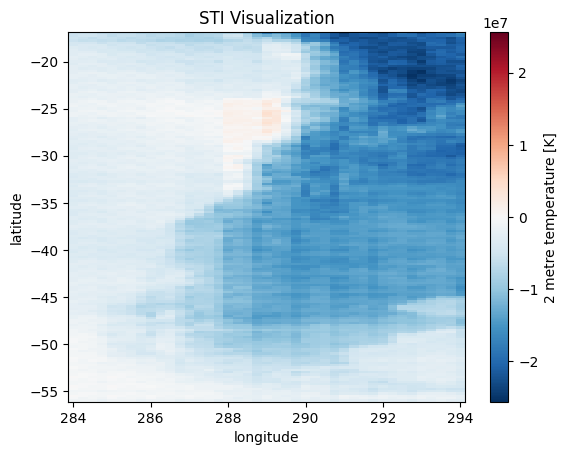

In [6]:
if ds:
    sub.plot()
    plt.title("STI Visualization")
    plt.show()